# EDS 296 Final Project
Authors: Haylee Oyler, Emma Bea Mitchell, Kimberlee Wong

## Region of Interest: Southeast Asia

## Introduction

Southeast Asia’s climate is tropical, hot, and humid. Monsoons are the most common extreme weather events, with the Southwest Monsoon in the summer months, and the Northeast Monsoon and tropical cyclones in the winter months. Countries’ economies in this region rely heavily on agriculture, alongside tourism and manufacturing. A more extreme increase in precipitation could greatly impact the agricultural sector, causing crops to die. An extreme decrease in precipitation could also be harmful as crops like rice rely on heavy rainfall for growth. An increase in temperature could also heavily impact agriculture in the region. Apart from economic issues, an increase in precipitation leads to extreme flooding which can shut down cities from days on end. Rising sea levels is also a large factor in this region’s vulnerability, and can lead to areas becoming uninhabitable. A rise in temperature also risks public health, leading to unsafe environments. 


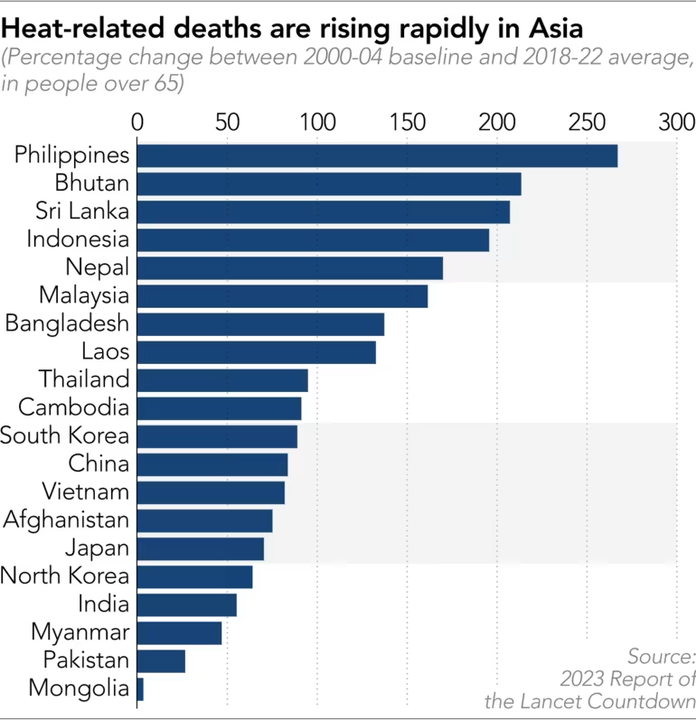

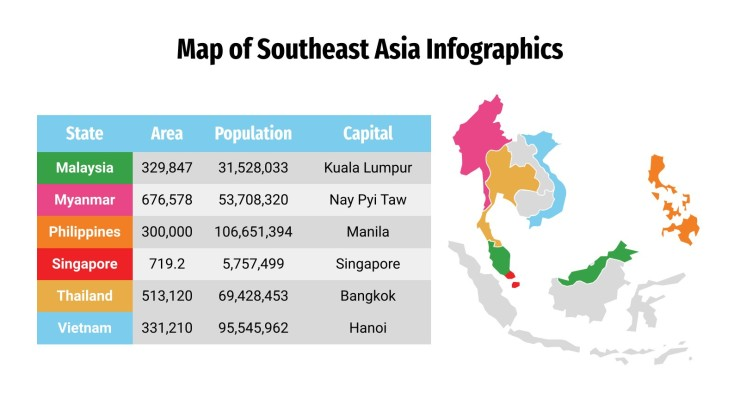

In [1]:
# Import packages
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import intake

In [2]:
# Open the CMIP6 data catalog, store as a variable
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')

# Convert the catalog to a df for easier access
cat_df = catalog.df

## Metrics Definition
We are picking the variables surface air temperature (tas) and precipitation (pr).

- Regional Averages: Visualizing the regional averages in Southeast Asia will help us understand how climate change is affecting temperature and precipitation in a tropical, productive region of the globe.
- Time Averages: Mapping changes in temperature and precipitation between historical and future projections in Southeast Asia will help display how extreme climate events will affect the future.

We chose CanESM5 and CESM2 as our models because they are widely available and our team had experience using these models in past assignments. 

## Data I/O

In [3]:
# Specify search terms to query catalog for CanESM5 data
# activity_id: Selecting CMIP for historical and ScenarioMIP for future projections
activity_ids = ['ScenarioMIP', 'CMIP'] 

# source_id: Models selected earlier
source_id = ['CanESM5', 'CESM2']

# experiment_id: I chose the historical data and the ssp370 projection as my two time experimental configurations
experiment_ids = ['historical', 'ssp370']

# member_id: Changed the ensemble member here because there was more data available
member_id = 'r10i1p1f1'

# table_id: Selecting monthly atmospheric data, which is the table that precipitation is stored in. 
table_id = 'Amon' 

# variable_id:  surface air temperature and precipitation
variable_id = ['tas', 'pr'] 

In [4]:
# Search through catalog, store results in "res" variable
res = catalog.search(activity_id=activity_ids, source_id=source_id, experiment_id=experiment_ids, 
                     member_id=member_id, table_id=table_id, variable_id=variable_id)

# Display data frame associated with results
display(res.df)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCAR,CESM2,historical,r10i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190313
1,CMIP,CCCma,CanESM5,historical,r10i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/CMIP/CCCma/CanESM5/histor...,NaN,20190429
2,CMIP,CCCma,CanESM5,historical,r10i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/CCCma/CanESM5/histor...,NaN,20190429
3,ScenarioMIP,CCCma,CanESM5,ssp370,r10i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CCCma/CanESM5...,NaN,20190429
4,ScenarioMIP,CCCma,CanESM5,ssp370,r10i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CCCma/CanESM5...,NaN,20190429
5,CMIP,NCAR,CESM2,historical,r10i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20200124
6,ScenarioMIP,NCAR,CESM2,ssp370,r10i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/NCAR/CESM2/ss...,NaN,20200528
7,ScenarioMIP,NCAR,CESM2,ssp370,r10i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/NCAR/CESM2/ss...,NaN,20200528


In [5]:
# Read in the historical data file for CESM2
hist_tas_cesm = xr.open_zarr(res.df['zstore'][0], storage_options={'anon': True})
hist_pr_cesm = xr.open_zarr(res.df['zstore'][5], storage_options={'anon': True})

# Read in 370 projections for CESM2
tas_cesm_370 = xr.open_zarr(res.df['zstore'][6], storage_options={'anon': True})
pr_cesm_370 = xr.open_zarr(res.df['zstore'][7], storage_options={'anon': True})

# Read in the historical data file for CanESM5
hist_tas_can = xr.open_zarr(res.df['zstore'][2], storage_options={'anon': True})
hist_pr_can = xr.open_zarr(res.df['zstore'][1], storage_options={'anon': True})

# Read in 370 projections for CanESM5
tas_can_370 = xr.open_zarr(res.df['zstore'][3], storage_options={'anon': True})
pr_can_370 = xr.open_zarr(res.df['zstore'][4], storage_options={'anon': True})

In [6]:
# Define function to generate area weights
def weights(dat):
    # Calculate weighting factor = cosine of latitude
    coslat = np.cos(np.deg2rad(dat.lat))
    weight_factor = coslat / coslat.mean(dim='lat')
    
    # Weight all points by the weighting factor
    computed_weight = dat * weight_factor
    
    # Return the set of weights: this has dimension equal to that of the input data
    return computed_weight

In [7]:
# Concatenate historical and future projection data
can_tas = xr.concat([hist_tas_can, tas_can_370], dim="time")

can_pr = xr.concat([hist_pr_can, pr_can_370], dim="time")

cesm_tas = xr.concat([hist_tas_cesm, tas_cesm_370], dim="time")

cesm_pr = xr.concat([hist_pr_cesm, pr_cesm_370], dim="time")


# Metrics Computation

## Regional Averages

### CanESM5 Computation

In [8]:
# Define region of interest
lat_min, lat_max = -11, 28
lon_min, lon_max = 92, 141

# Define logical mask: True when lat/lon inside the valid ranges, False elsewhere
tas_lat = (can_tas.lat >= lat_min) & (can_tas.lat <= lat_max)
tas_lon = (can_tas.lon >= lon_min) & (can_tas.lon <= lon_max)

# Define logical mask 2: True when lat/lon inside the valid ranges, False elsewhere
pr_lat = (can_pr.lat >= lat_min) & (can_pr.lat <= lat_max)
pr_lon = (can_pr.lon >= lon_min) & (can_pr.lon <= lon_max)

# Find points where the mask value is True, drop all other points
tas_E = can_tas.where(tas_lat & tas_lon, drop=True)

pr_E = can_pr.where(pr_lat & pr_lon, drop=True)

# Apply area weights
tas_weighted = weights(tas_E)
pr_weighted = weights(pr_E)

# Compute annually averaged, regionally averaged time series
tas_annual = tas_weighted.mean(dim=["lat", "lon"]).resample(time="1Y").mean()
pr_annual = pr_weighted.mean(dim=["lat", "lon"]).resample(time="1Y").mean()

# Save tas variable
tas_annual = tas_annual["tas"] - 273.15
pr_annual = pr_annual["pr"]

# Convert time to datetime64 format
time = tas_annual.time.astype('datetime64[ns]')
time2 = pr_annual.time.astype('datetime64[ns]')

In [9]:
# Calculate the annual mean surface air temp 
mean_tas_can = tas_annual.groupby('time.year').mean()

# Calculate best-fit parameters for the linear polynomial fit of precipitation to year
poly_tas_can = np.polyfit(mean_tas_can.year, mean_tas_can, 1)

# Generate a polynomial object using those best-fit parameters
trend_tas_can = np.poly1d(poly_tas_can) 

In [10]:
# Calculate the annual mean precipitation
mean_pr_can = pr_annual.groupby('time.year').mean()

# Calculate best-fit parameters for the linear polynomial fit of precipitation to year
poly_pr_can = np.polyfit(mean_pr_can.year, mean_pr_can, 1)

# Generate a polynomial object using those best-fit parameters
trend_pr_can = np.poly1d(poly_pr_can) 

### CESM2 Computation

In [11]:
# Define logical mask: True when lat/lon inside the valid ranges, False elsewhere
tas_lat_cesm = (cesm_tas.lat >= lat_min) & (cesm_tas.lat <= lat_max)
tas_lon_cesm = (can_tas.lon >= lon_min) & (cesm_tas.lon <= lon_max)

# Define logical mask 2: True when lat/lon inside the valid ranges, False elsewhere
pr_lat_cesm = (cesm_pr.lat >= lat_min) & (cesm_pr.lat <= lat_max)
pr_lon_cesm = (cesm_pr.lon >= lon_min) & (cesm_pr.lon <= lon_max)

# Find points where the mask value is True, drop all other points
tas_E_cesm = cesm_tas.where(tas_lat_cesm & tas_lon_cesm, drop=True)

pr_E_cesm = cesm_pr.where(pr_lat_cesm & pr_lon_cesm, drop=True)

# Apply area weights
tas_weighted_cesm = weights(tas_E_cesm)
pr_weighted_cesm = weights(pr_E_cesm)

# Compute annually averaged, regionally averaged time series
tas_annual_cesm = tas_weighted_cesm.mean(dim=["lat", "lon"]).resample(time="1Y").mean()
pr_annual_cesm = pr_weighted_cesm.mean(dim=["lat", "lon"]).resample(time="1Y").mean()

# Save tas variable
tas_annual_cesm = tas_annual_cesm["tas"] - 273.15
pr_annual_cesm = pr_annual_cesm["pr"]

# Convert time to datetime64 format
time = tas_annual_cesm.time.astype('datetime64[ns]')
time2 = pr_annual_cesm.time.astype('datetime64[ns]')

In [12]:
# Calculate the annual mean surface air temp 
mean_tas_cesm = tas_annual_cesm.groupby('time.year').mean()

# Calculate best-fit parameters for the linear polynomial fit of precipitation to year
poly_tas_cesm = np.polyfit(mean_tas_cesm.year, mean_tas_cesm, 1)

# Generate a polynomial object using those best-fit parameters
trend_tas_cesm = np.poly1d(poly_tas_cesm) 

In [13]:
# Calculate the annual mean precipitation
mean_pr_cesm = pr_annual_cesm.groupby('time.year').mean()

# Calculate best-fit parameters for the linear polynomial fit of precipitation to year
poly_pr_cesm = np.polyfit(mean_pr_cesm.year, mean_pr_cesm, 1)

# Generate a polynomial object using those best-fit parameters
trend_pr_cesm = np.poly1d(poly_pr_cesm) 

## Time Averages


In [14]:
# Define min/max bounds for Southeast Asia
region = [92, 141, -11, 28] 
# [lon_min, lon_max, lat_min, lat_max]

# Time periods of interest
per_early = [1975, 2025]
per_late = [2026, 2075]

# Fix datetime format
cesm_tas['time'] = cesm_tas.time.astype('datetime64[ns]')
cesm_pr['time'] = cesm_pr.time.astype('datetime64[ns]')
can_tas['time'] = can_tas.time.astype('datetime64[ns]')
can_pr['time'] = can_pr.time.astype('datetime64[ns]')

# Sort by time for filtering later on
tas_cesm = cesm_tas.sortby('time')
pr_cesm = cesm_pr.sortby('time')
tas_can = can_tas.sortby('time')
pr_can = can_pr.sortby('time')

In [15]:
# Slice the data to the time periods
# CESM tas historical
tas_cesm_hist = tas_cesm.sel(time=slice(str(per_early[0])+"-01-01", str(per_early[1])+"-12-31"))
# CESM tas future
tas_cesm_fut = tas_cesm.sel(time=slice(str(per_late[0])+"-01-01", str(per_late[1])+"-12-31"))

# CESM pr historical
pr_cesm_hist = pr_cesm.sel(time=slice(str(per_early[0])+"-01-01", str(per_early[1])+"-12-31"))
# CESM pr future
pr_cesm_fut = pr_cesm.sel(time=slice(str(per_late[0])+"-01-01", str(per_late[1])+"-12-31"))

# CESM tas historical
tas_can_hist = tas_can.sel(time=slice(str(per_early[0])+"-01-01", str(per_early[1])+"-12-31"))
# can tas future
tas_can_fut = tas_can.sel(time=slice(str(per_late[0])+"-01-01", str(per_late[1])+"-12-31"))

# can pr historical
pr_can_hist = pr_can.sel(time=slice(str(per_early[0])+"-01-01", str(per_early[1])+"-12-31"))
# can pr future
pr_can_fut = pr_can.sel(time=slice(str(per_late[0])+"-01-01", str(per_late[1])+"-12-31"))



In [16]:
# Calculate the annual mean tas for each model and extract values
# tas CESM historical
tas_cesm_hist_mean = tas_cesm_hist.mean(dim="time") - 273.15
tas_cesm_hist_mean_val = tas_cesm_hist_mean.tas.values

# tas CESM future
tas_cesm_fut_mean = tas_cesm_fut.mean(dim="time") - 273.15
tas_cesm_fut_mean_val = tas_cesm_fut_mean.tas.values

# pr CESM historical
pr_cesm_hist_mean = pr_cesm_hist.mean(dim="time")
pr_cesm_hist_mean_val = pr_cesm_hist_mean.pr.values

# pr CESM future
pr_cesm_fut_mean = pr_cesm_fut.mean(dim="time")
pr_cesm_fut_mean_val = pr_cesm_fut_mean.pr.values

# tas can historical
tas_can_hist_mean = tas_can_hist.mean(dim="time") - 273.15
tas_can_hist_mean_val = tas_can_hist_mean.tas.values

# tas can future
tas_can_fut_mean = tas_can_fut.mean(dim="time") - 273.15
tas_can_fut_mean_val = tas_can_fut_mean.tas.values

# pr can historical
pr_can_hist_mean = pr_can_hist.mean(dim="time")
pr_can_hist_mean_val = pr_can_hist_mean.pr.values

# pr can future
pr_can_fut_mean = pr_can_fut.mean(dim="time")
pr_can_fut_mean_val = pr_can_fut_mean.pr.values


## Visualizations

### CanESM5 Surface Air Temperature Regional Time Series

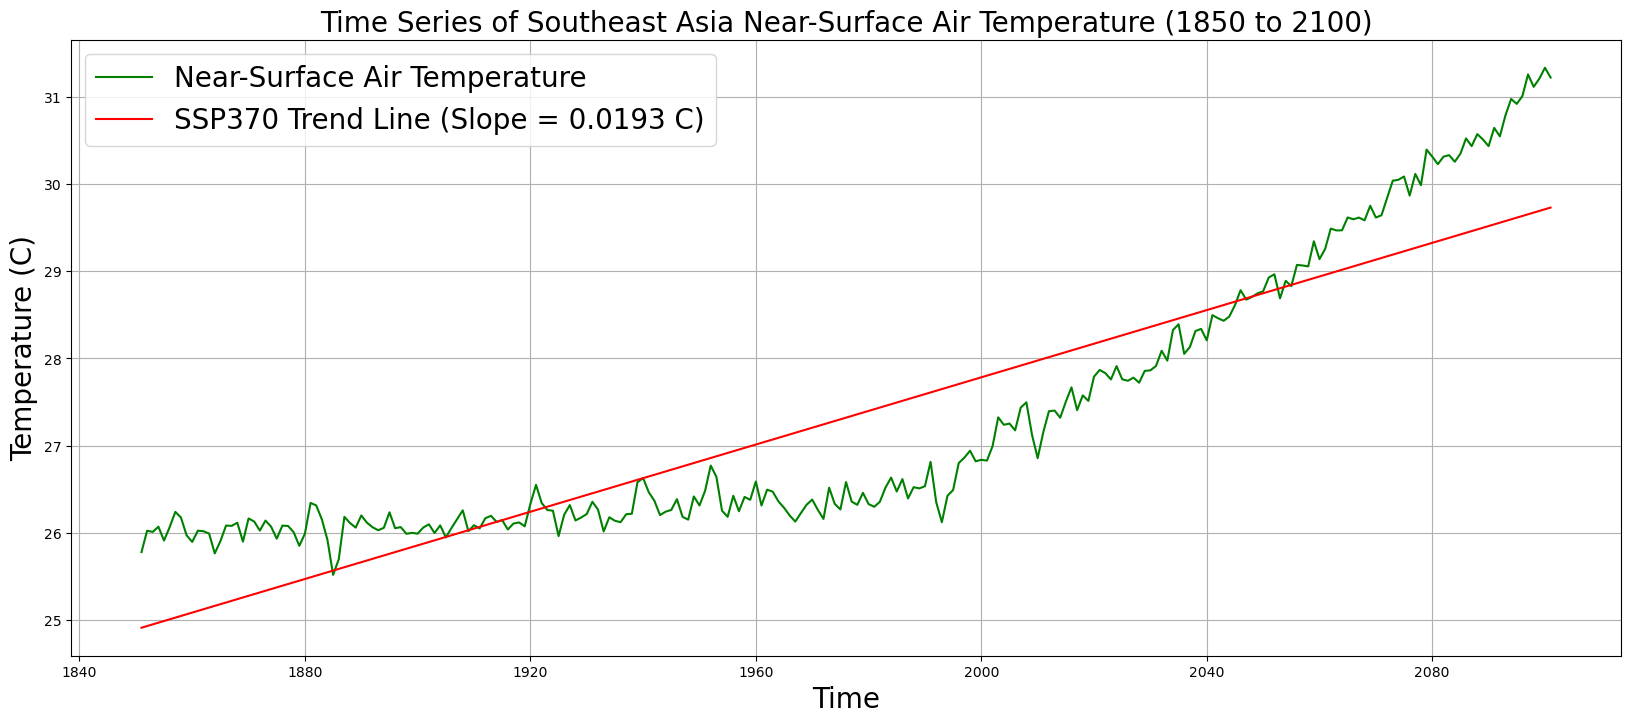

In [17]:
fig, ax = plt.subplots(figsize=(20, 8))

# Plot the time series
ax.plot(time, tas_annual, label="Near-Surface Air Temperature", color="g")
ax.plot(time, trend_tas_can(mean_tas_can.year), color='red', label=f'SSP370 Trend Line (Slope = {poly_tas_can[0]:.4f} C)')

# Add title and labels
ax.set_title("Time Series of Southeast Asia Near-Surface Air Temperature (1850 to 2100)", fontsize=20)
ax.set_xlabel("Time", fontsize=20)
ax.set_ylabel("Temperature (C)", fontsize=20)

# Add legend
ax.legend(fontsize=20)

# Add grid
ax.grid()

plt.show()

### CanESM5 Difference in Surface Air Temperature (Future - Historical)

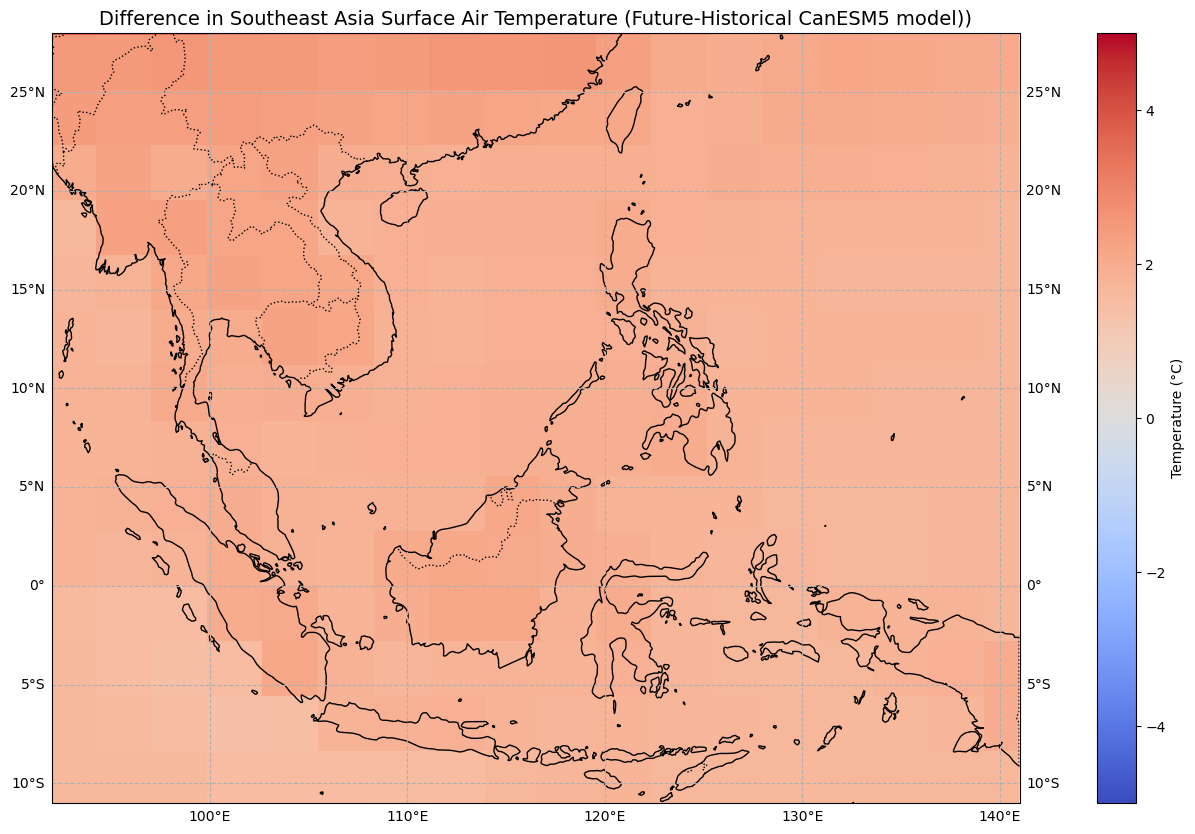

In [18]:
# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})

# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(tas_can_hist_mean.lon, tas_can_hist_mean.lat, 
                     tas_can_fut_mean_val - tas_can_hist_mean_val, 
                     transform=map, cmap="coolwarm", vmin=-5, vmax=5)

# Set spatial extent of plot
ax.set_extent(region, crs=ccrs.PlateCarree())

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)")

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False

# Add title, show plot
ax.set_title("Difference in Southeast Asia Surface Air Temperature (Future-Historical CanESM5 model))", fontsize= 14)
plt.show()

### CanESM5 Average Precipitation Flux Regional Time Series


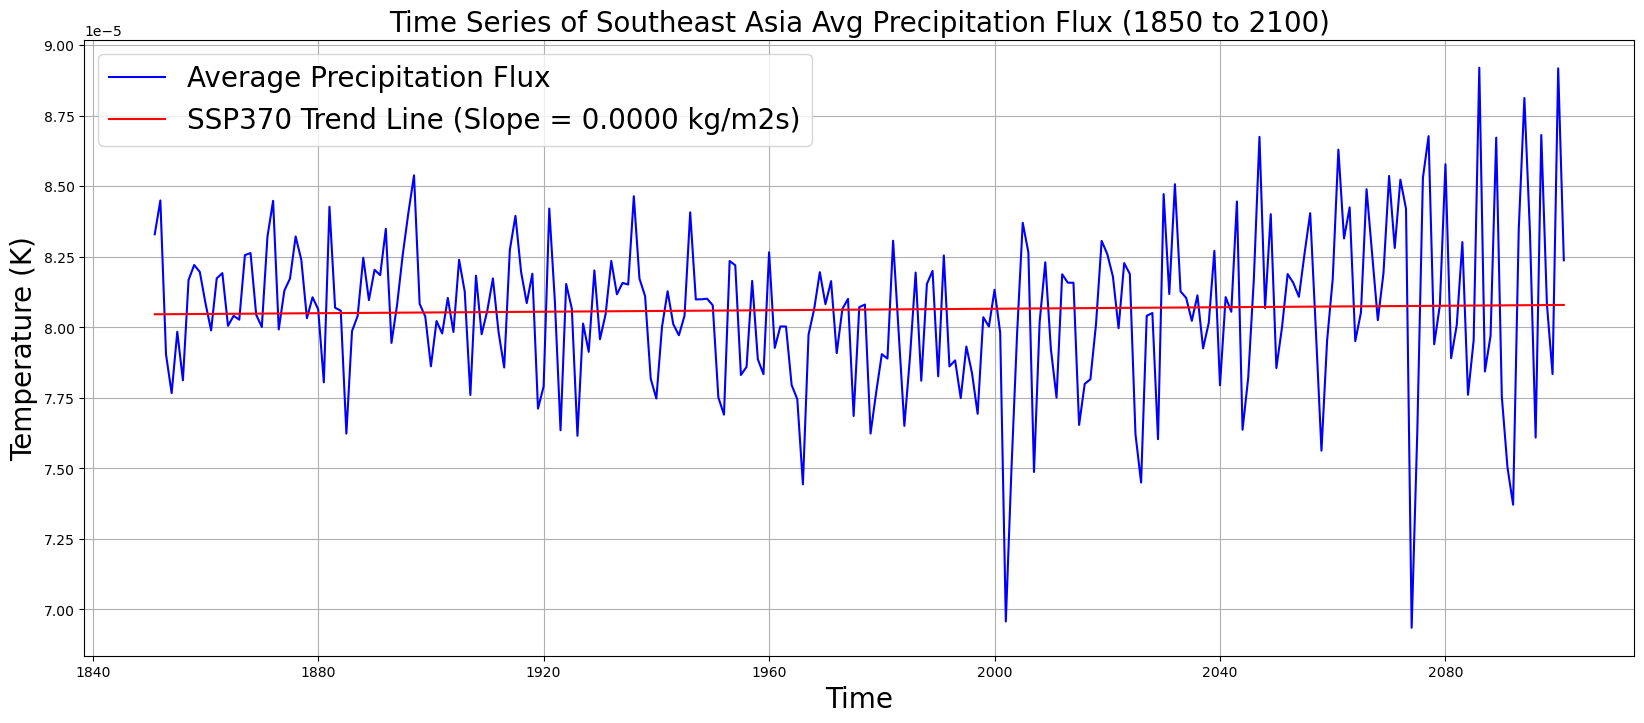

In [19]:
fig, ax = plt.subplots(figsize=(20, 8))

# Plot the time series
ax.plot(time2, pr_annual, label="Average Precipitation Flux", color="b")
ax.plot(time2, trend_pr_can(mean_pr_can.year), color='red', label=f'SSP370 Trend Line (Slope = {poly_pr_can[0]:.4f} kg/m2s)')

# Add title and labels
ax.set_title("Time Series of Southeast Asia Avg Precipitation Flux (1850 to 2100)", fontsize=20)
ax.set_xlabel("Time", fontsize=20)
ax.set_ylabel("Temperature (K)", fontsize=20)

# Add legend
ax.legend(fontsize=20)

# Add grid
ax.grid()

plt.show()

### CanESM5 Difference in Average Precipitation Flux (Future - Historical)

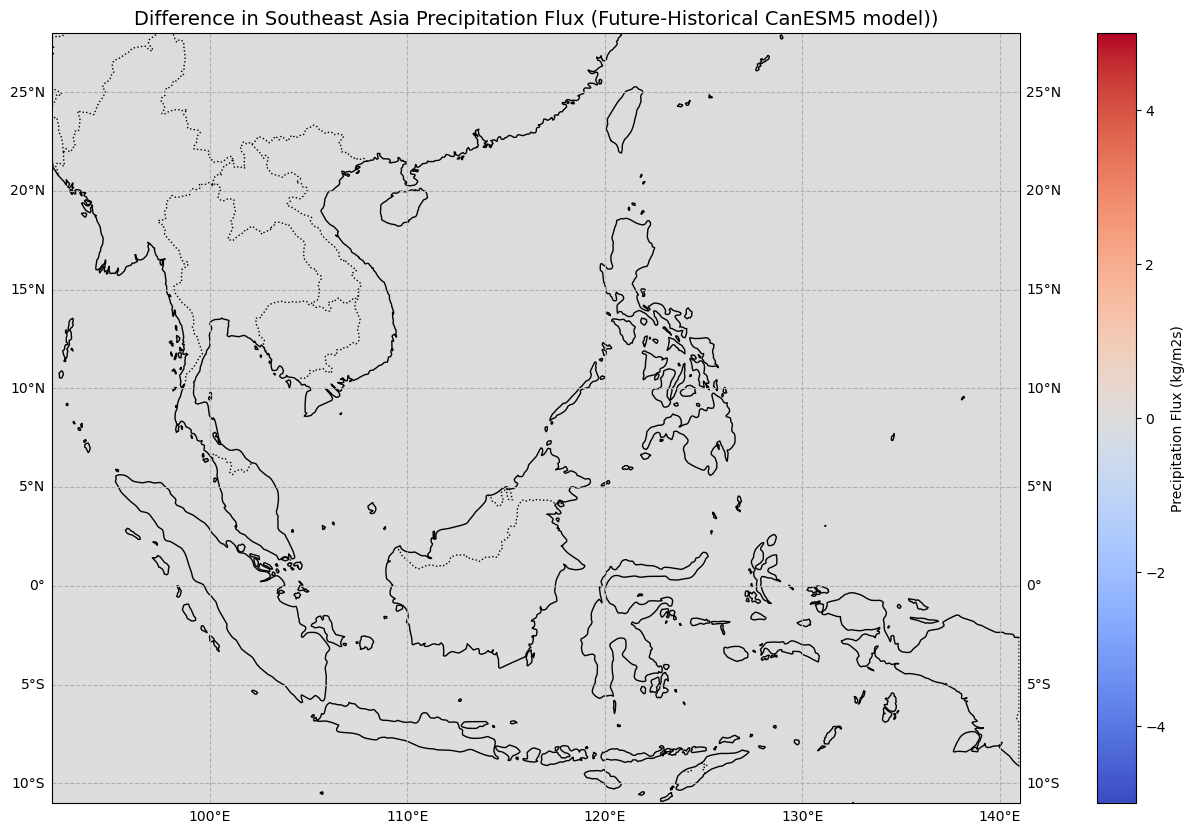

In [20]:

# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})

# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(pr_can_hist_mean.lon, pr_can_hist_mean.lat, 
                     pr_can_fut_mean_val - pr_can_hist_mean_val, 
                     transform=map, cmap="coolwarm", vmin=-5, vmax=5)

# Set spatial extent of plot
ax.set_extent(region, crs=ccrs.PlateCarree())

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Precipitation Flux (kg/m2s)")

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False

# Add title, show plot
ax.set_title("Difference in Southeast Asia Precipitation Flux (Future-Historical CanESM5 model))", fontsize= 14)
plt.show()

### CESM2 Average Surface Air Temperature Regional Time Series

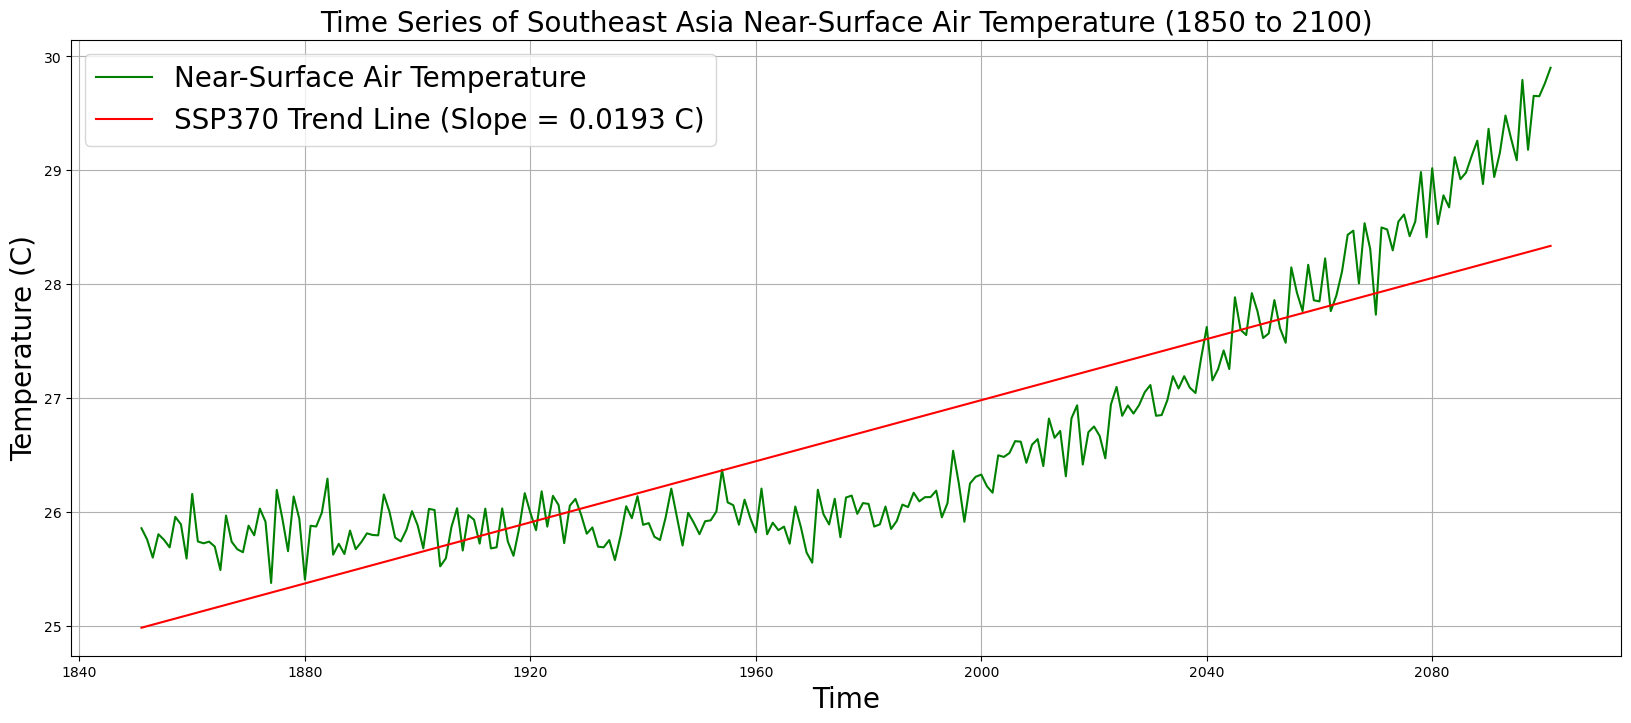

In [21]:
fig, ax = plt.subplots(figsize=(20, 8))

# Plot the time series
ax.plot(time, tas_annual_cesm, label="Near-Surface Air Temperature", color="g")
ax.plot(time, trend_tas_cesm(mean_tas_cesm.year), color='red', label=f'SSP370 Trend Line (Slope = {poly_tas_can[0]:.4f} C)')

# Add title and labels
ax.set_title("Time Series of Southeast Asia Near-Surface Air Temperature (1850 to 2100)", fontsize=20)
ax.set_xlabel("Time", fontsize=20)
ax.set_ylabel("Temperature (C)", fontsize=20)

# Add legend
ax.legend(fontsize=20)

# Add grid
ax.grid()

plt.show()

### CESM2 Difference in Surface Air Temperature (Future - Historical)

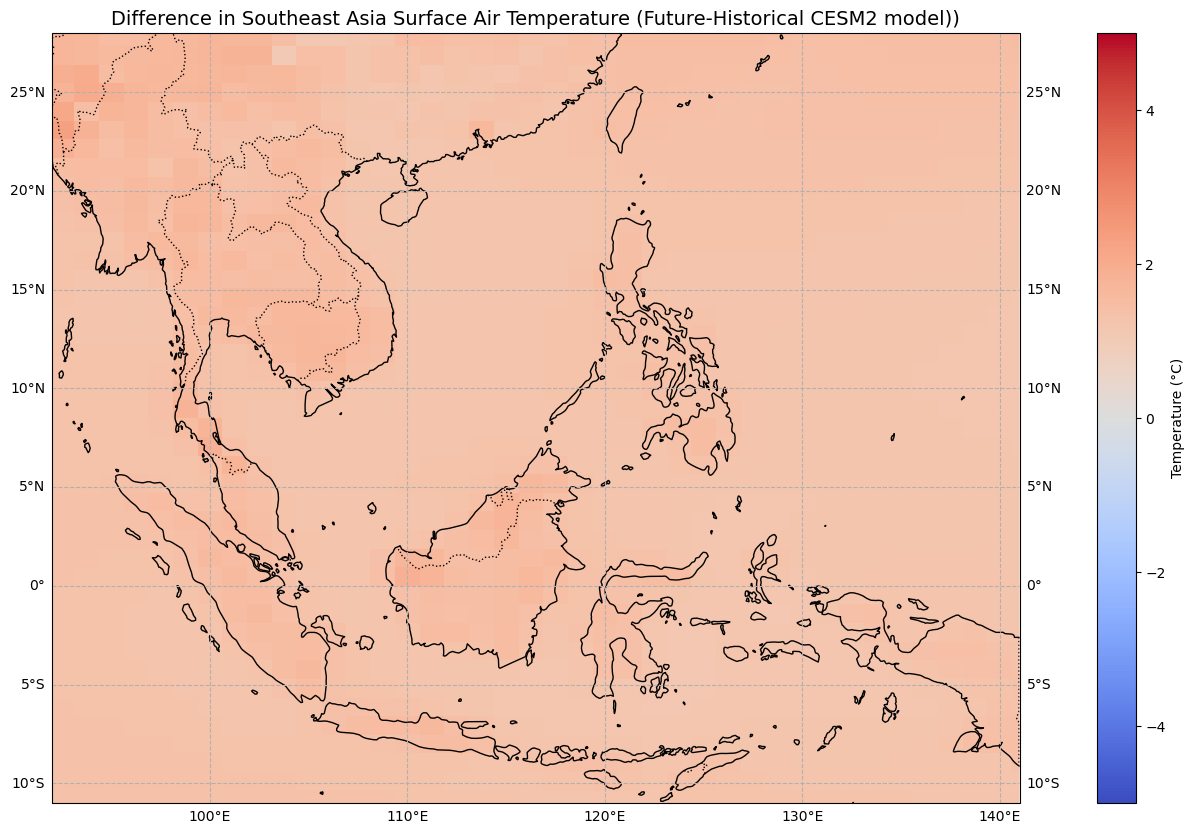

In [22]:
# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})

# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(tas_cesm_hist_mean.lon, tas_cesm_hist_mean.lat, 
                     tas_cesm_fut_mean_val - tas_cesm_hist_mean_val, 
                     transform=map, cmap="coolwarm", vmin=-5, vmax=5)

# Set spatial extent of plot
ax.set_extent(region, crs=ccrs.PlateCarree())

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)")

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False

# Add title, show plot
ax.set_title("Difference in Southeast Asia Surface Air Temperature (Future-Historical CESM2 model))", fontsize= 14)
plt.show()






### CESM2 Average Precipitation Flux Regional Time Series


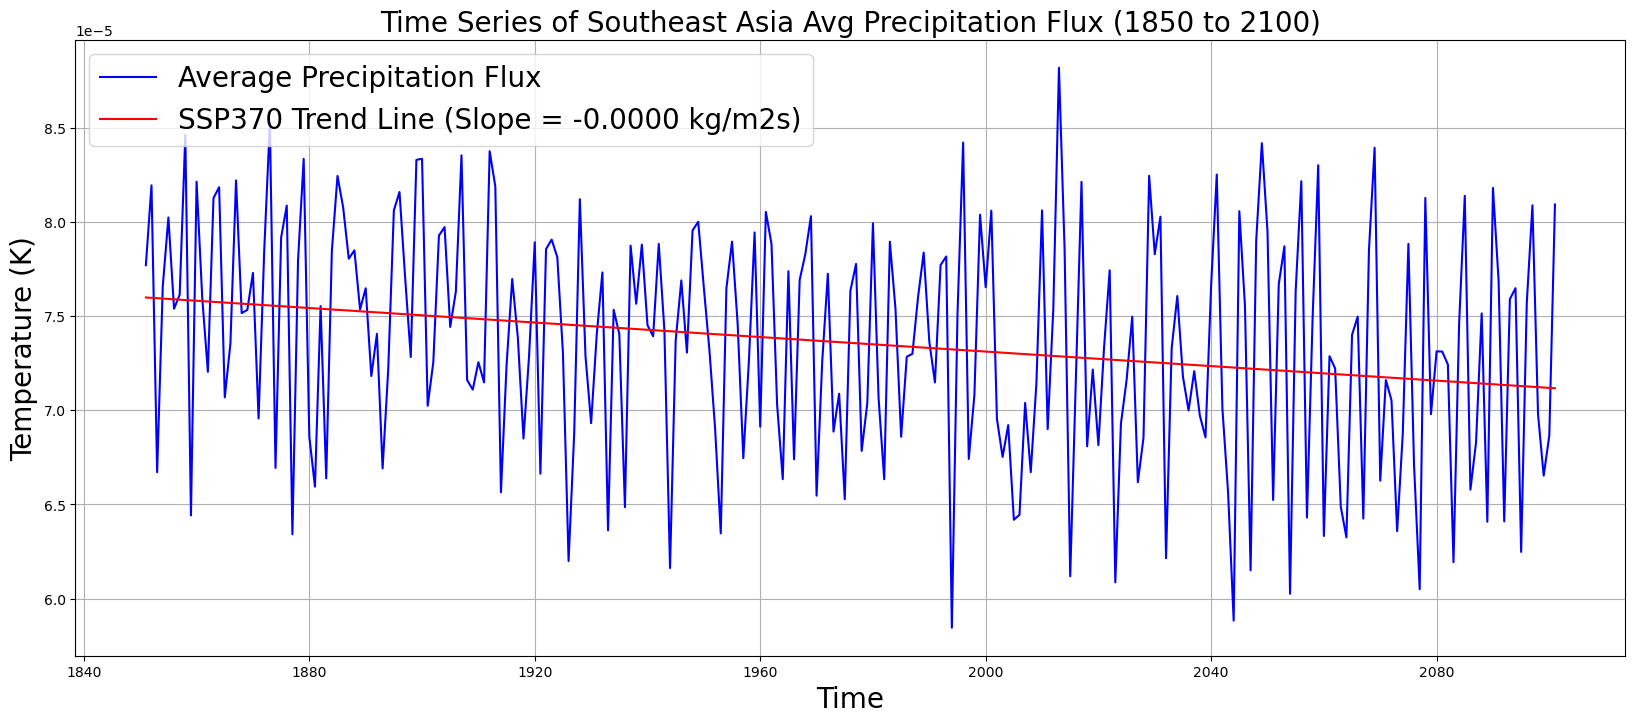

In [23]:
fig, ax = plt.subplots(figsize=(20, 8))

# Plot the time series
ax.plot(time2, pr_annual_cesm, label="Average Precipitation Flux", color="b")
ax.plot(time2, trend_pr_cesm(mean_pr_cesm.year), color='red', label=f'SSP370 Trend Line (Slope = {poly_pr_cesm[0]:.4f} kg/m2s)')

# Add title and labels
ax.set_title("Time Series of Southeast Asia Avg Precipitation Flux (1850 to 2100)", fontsize=20)
ax.set_xlabel("Time", fontsize=20)
ax.set_ylabel("Temperature (K)", fontsize=20)

# Add legend
ax.legend(fontsize=20)

# Add grid
ax.grid()

plt.show()

### CESM2 Difference in Average Precipitation Flux (Future - Historical)

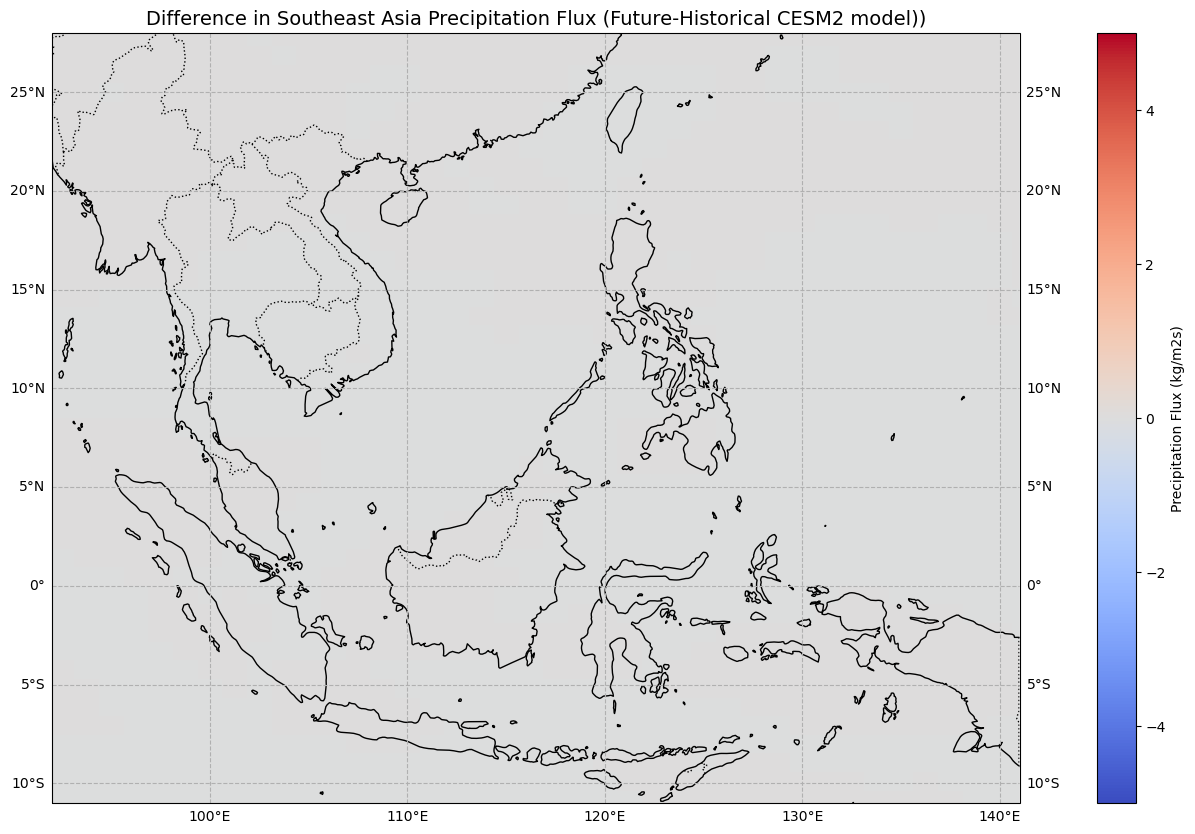

In [24]:
# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})

# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(pr_cesm_hist_mean.lon, pr_cesm_hist_mean.lat, 
                     pr_cesm_fut_mean_val - pr_cesm_hist_mean_val, 
                     transform=map, cmap="coolwarm", vmin=-5, vmax=5)

# Set spatial extent of plot
ax.set_extent(region, crs=ccrs.PlateCarree())

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Precipitation Flux (kg/m2s)")

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False

# Add title, show plot
ax.set_title("Difference in Southeast Asia Precipitation Flux (Future-Historical CESM2 model))", fontsize= 14)
plt.show()

## Conclusion

We found interesting results for both our models. For both CESM2 and CanEsm5, the temperature is increasing. This could be harmful to people in Southeast Asia  who rely on agriculture for their livelihoods, and crops will be greatly affected. On a global scale, a rise in temperature will also lead to a rise in sea level, of which the people in the region are very vulnerable to. Ecosystems will also be impacted, as warmer temperatures will make the area unsuitable for many flora and fauna.

While the temperature increase is fairly consistent within our models, the precipitation is not as similar. In CanESM5, the precipitation flux was very flat, with barely any increase shown. In CESM2, the precipitation flux was also fairly flat, although it had a negative trend. This was opposite of our expected results, and made us wonder about our choices of model and how accurate they were in the region. When looking up research in the region, it seemed like most scientists expect there to be an increase in precipitation due to climate change. This was another reason to question our model’s findings. If our model is correct, the lack of projected change could be a good sign for the people and ecosystems in Southeast Asia, as a more stable rainfall means there will not be an increase in extreme weather like floods or monsoons. This result was very interesting to us, and we are excited to talk about this lack of flux in precipitation with the class and see their results.